# Лабораторна робота 2: Моделювання лінійних систем

**Студент групи ФБ-41мн:** Зубко Дмитро Едуардович

## Опис завдання

Мета роботи – оволодіння засобами пакету scipy для імітаційного моделювання лінійних неперервних систем.

### Варіант 8

## 2.1.1. Передатні функції лінійних ланок

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import control
import control as ctrl
import control as ctl

In [3]:
# 1. Задання передатної функції
numerator = [1, 0, 0, -2]  # p^3 - 2
denominator = [4, 1, 2, 3]  # 4p^3 + p^2 + 2p + 3

# Створення передатної функції
sys = signal.TransferFunction(numerator, denominator)

In [4]:
# 2. Знаходження нулів, полюсів та коефіцієнту підсилення
zeros, poles, k = signal.tf2zpk(numerator, denominator)

print("Нулі передатної функції:", zeros)
print("Полюси передатної функції:", poles)
print("Коефіцієнт підсилення:", k)

Нулі передатної функції: [-0.62996052+1.09112364j -0.62996052-1.09112364j  1.25992105+0.j        ]
Полюси передатної функції: [ 0.27450443+0.92914491j  0.27450443-0.92914491j -0.79900886+0.j        ]
Коефіцієнт підсилення: 0.25


In [5]:
# 3. Перевірка стійкості
stable = np.all(np.real(poles) < 0)
print("\nСистема стійка:" if stable else "\nСистема нестійка:")
print("Дійсні частини полюсів:", np.real(poles))


Система нестійка:
Дійсні частини полюсів: [ 0.27450443  0.27450443 -0.79900886]


In [6]:
# 4. Створення системи зі зворотним зв'язком
def create_closed_loop_system(kuk_uku):
    # Створення відкритої системи
    open_loop = signal.TransferFunction(numerator, denominator)

    # Створення замкненої системи з від'ємним зворотним зв'язком
    closed_loop_num = open_loop.num
    closed_loop_den = np.polyadd(open_loop.den, kuk_uku * open_loop.num)
    closed_loop = signal.TransferFunction(closed_loop_num, closed_loop_den)
    return closed_loop

# Знаходження стійкого значення kuk_uku
kuk_uku_values = np.linspace(0.1, 2, 100)
stable_k = None

for k in kuk_uku_values:
    closed_sys = create_closed_loop_system(k)
    poles_cl = closed_sys.poles
    if np.all(np.real(poles_cl) < 0):
        stable_k = k
        break

print(f"\nЗнайдене стійке значення kuk_uku: {stable_k}")

# Створюємо стійку замкнену систему
stable_sys = create_closed_loop_system(stable_k)
print("\nПередатна функція стійкої замкненої системи:")
print(stable_sys)


Знайдене стійке значення kuk_uku: 1.3282828282828283

Передатна функція стійкої замкненої системи:
TransferFunctionContinuous(
array([ 0.18767773,  0.        ,  0.        , -0.37535545]),
array([1.        , 0.18767773, 0.37535545, 0.06445498]),
dt: None
)


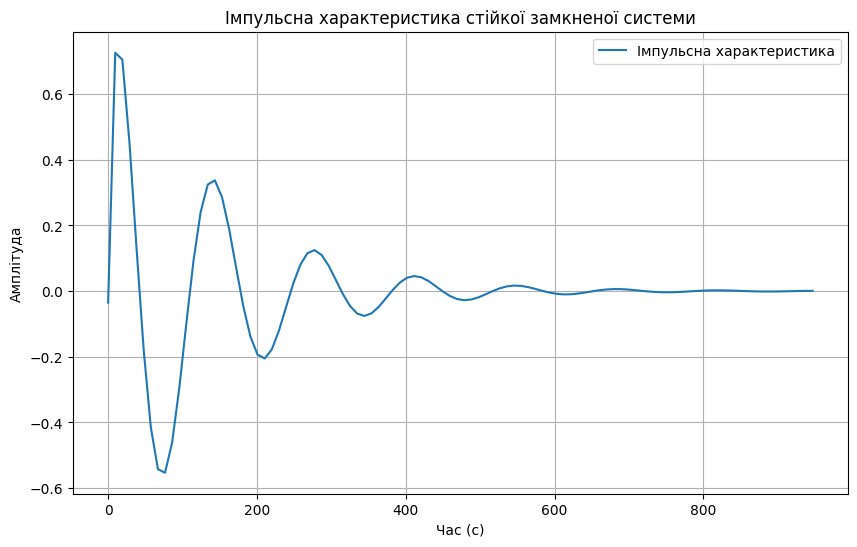

In [7]:
# Отримуємо імпульсну характеристику стійкої замкненої системи
t, response = signal.impulse(stable_sys)

# Побудова графіка імпульсної характеристики
plt.figure(figsize=(10, 6))
plt.plot(t, response, label='Імпульсна характеристика')
plt.title('Імпульсна характеристика стійкої замкненої системи')
plt.xlabel('Час (с)')
plt.ylabel('Амплітуда')
plt.grid(True)
plt.legend()
plt.show()

Висновок: система реагує на імпульс зі значними коливаннями вихідної величини перед стабілізацією.

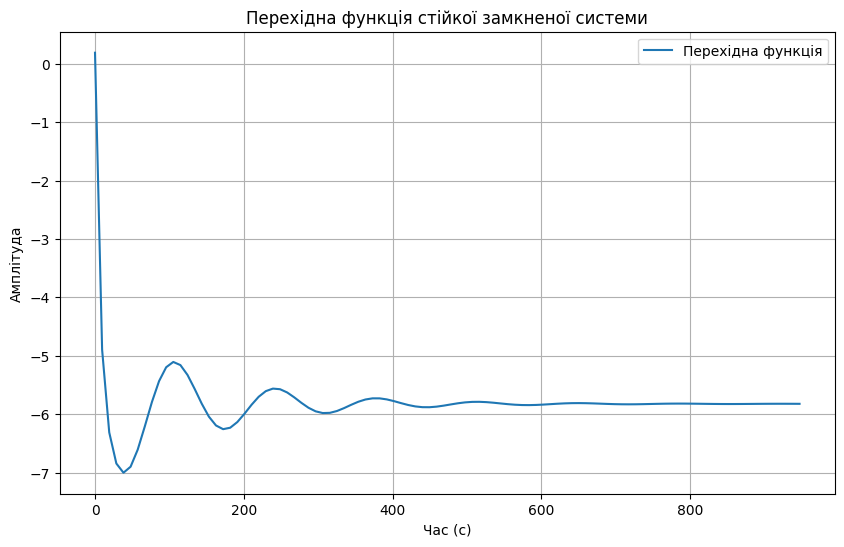

In [8]:
# Отримуємо перехідну функцію стійкої замкненої системи
t, step_response = signal.step(stable_sys)

# Побудова графіка перехідної функції
plt.figure(figsize=(10, 6))
plt.plot(t, step_response, label='Перехідна функція')
plt.title('Перехідна функція стійкої замкненої системи')
plt.xlabel('Час (с)')
plt.ylabel('Амплітуда')
plt.grid(True)
plt.legend()
plt.show()

Висновок: система має сильно коливальну перехідну функцію. Це вказує на слабку демпфованість системи, яка схильна до перерегулювання та тривалого часу перехідного процесу. Такі коливання та нестабільність поведінки системи ускладнюватимуть точне регулювання та керування нею.

Коефіцієнт підсилення вихідного сигналу: 1.8088565035321016
Зсув фази вихідного сигналу: 75.78199294315492 градусів


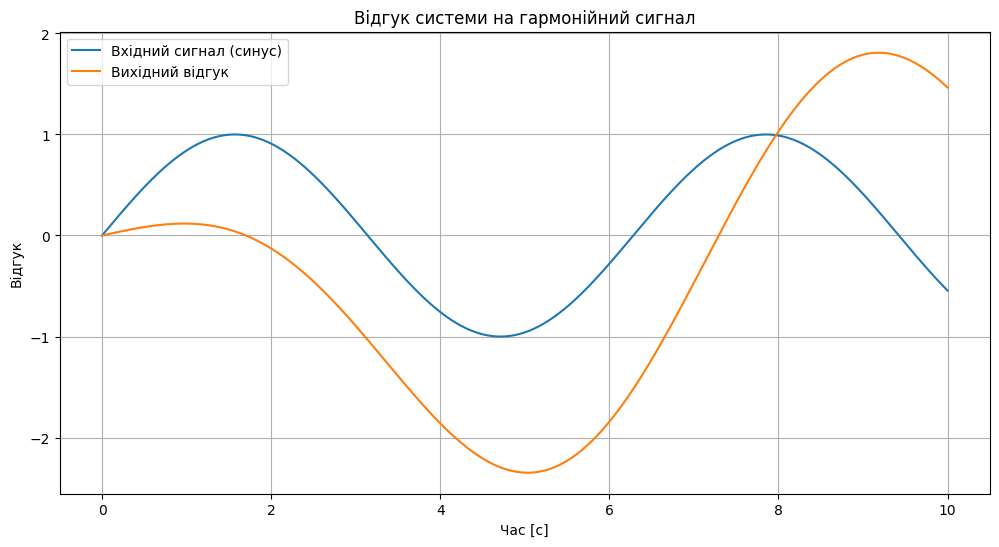

In [9]:
# Відгук на гармонійний сигнал
t = np.linspace(0, 10, 500)
u = np.sin(t)
t, yout, _ = signal.lsim(stable_sys, u, t)

amp_input = np.max(u)
amp_output = np.max(yout)

#Коефіцієнт посилення
gain = amp_output / amp_input

#фазове зміщення
peak_input = t[np.argmax(u)]
peak_output = t[np.argmax(yout)]

#дельта часу
time_shift = peak_output - peak_input

phase_shift_rad = (time_shift / (2 * np.pi)) * 360  #в градуси

print(f"Коефіцієнт підсилення вихідного сигналу: {gain}")
print(f"Зсув фази вихідного сигналу: {phase_shift_rad} градусів")

#Графік
plt.figure(figsize=(12, 6))
plt.plot(t, u, label='Вхідний сигнал (синус)')
plt.plot(t, yout, label='Вихідний відгук')
plt.title('Відгук системи на гармонійний сигнал')
plt.xlabel('Час [с]')
plt.ylabel('Відгук')
plt.legend()
plt.grid(True)
plt.show()

#### Про відгук системи на гармонійний сигнал
Система є підсилювальною, тобто вона збільшує амплітуду вхідного гармонічного сигналу приблизно в 1.81 рази. Однак система також має фазовий зсув, що свідчить про випереджувальний характер.

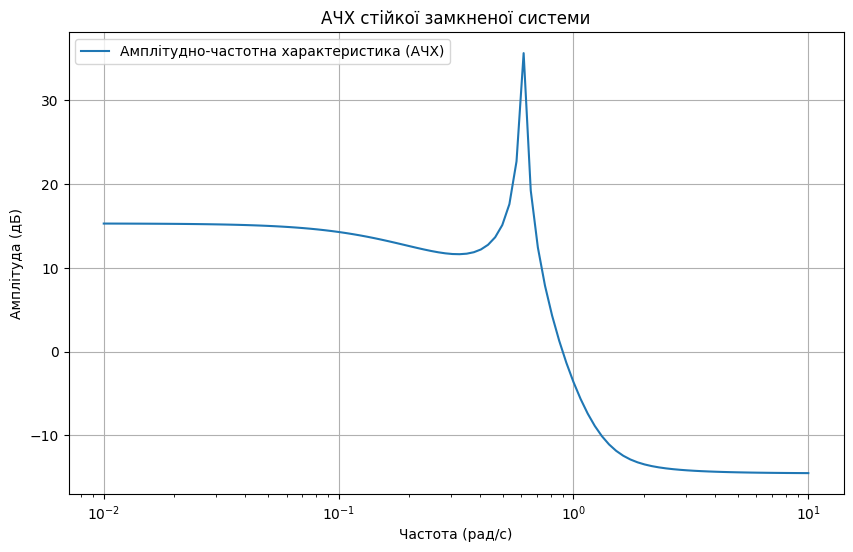

In [10]:
# 6. Частотні характеристики
# Отримуємо частотну характеристику
w, mag, phase = signal.bode(stable_sys)

# Побудова графіка АЧХ
plt.figure(figsize=(10, 6))
plt.semilogx(w, mag, label='Амплітудно-частотна характеристика (АЧХ)')
plt.title('АЧХ стійкої замкненої системи')
plt.xlabel('Частота (рад/с)')
plt.ylabel('Амплітуда (дБ)')
plt.grid(True)
plt.legend()
plt.show()

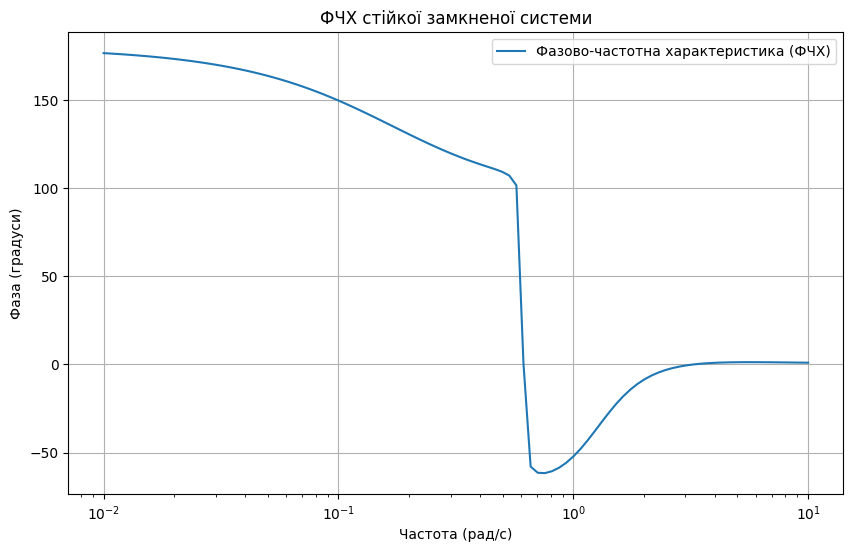

In [11]:
# Побудова графіка ФЧХ
plt.figure(figsize=(10, 6))
plt.semilogx(w, phase, label='Фазово-частотна характеристика (ФЧХ)')
plt.title('ФЧХ стійкої замкненої системи')
plt.xlabel('Частота (рад/с)')
plt.ylabel('Фаза (градуси)')
plt.grid(True)
plt.legend()
plt.show()

### Висновок про графіки АЧХ та ФЧХ
Наявність виразного резонансного піку на АЧХ вказує на те, що в системі присутні резонансні явища. Це означає, що система має недостатнє демпфування та може схильна до коливань і перерегулювання.

Зв'язок між резонансними явищами та стійкістю полягає в тому, що надмірно виражені резонанси, особливо при низькому демпфуванні, зазвичай погіршують стійкість системи. Сильні резонанси можуть призводити до втрати стійкості або автоколивань.

Між АЧХ та ФЧХ існує тісний взаємозв'язок. Форма ФЧХ визначається характером АЧХ. Різкі підйоми та спади на АЧХ відповідають різким змінам фази на ФЧХ. Тому аналіз АЧХ дозволяє зрозуміти особливості та поведінку ФЧХ системи.

### Годограф Найквіста

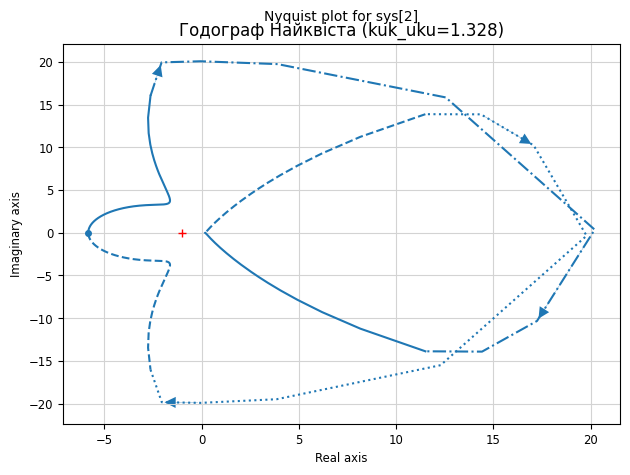

In [12]:
G = control.TransferFunction(numerator, denominator)
G = control.feedback(G, stable_k)

# Годограф Найквіста
control.nyquist_plot(G)
plt.title(f'Годограф Найквіста (kuk_uku={stable_k:.3f})')
plt.grid(True)
plt.show()

Висновок: годограф демонструє стійку коливну поведінку системи, про що свідчить те, що він обходить точку (-1,0) на комплексній площині. Це означає, що система може бути схильна до автоколивань.
Запас стійкості системи за фазою невеликий, що може викликати проблеми з її демпфуванням та стабільністю.
Підтвердженням слабкого демпфування є той факт, що годограф має витягнуту та незакриту форму, а не компактну замкнену.

                                                           2                              3                            ↪
                             d                            d                              d                             ↪
1.0⋅y(t) + 0.187677725118483⋅──(y(t)) + 0.375355450236967⋅───(y(t)) + 0.0644549763033175⋅───(y(t)) = 0.187677725118483 ↪
                             dt                             2                              3                           ↪
                                                          dt                             dt                            ↪

↪                            3       
↪                           d        
↪ ⋅u(t) - 0.375355450236967⋅───(u(t))
↪                             3      
↪                           dt       


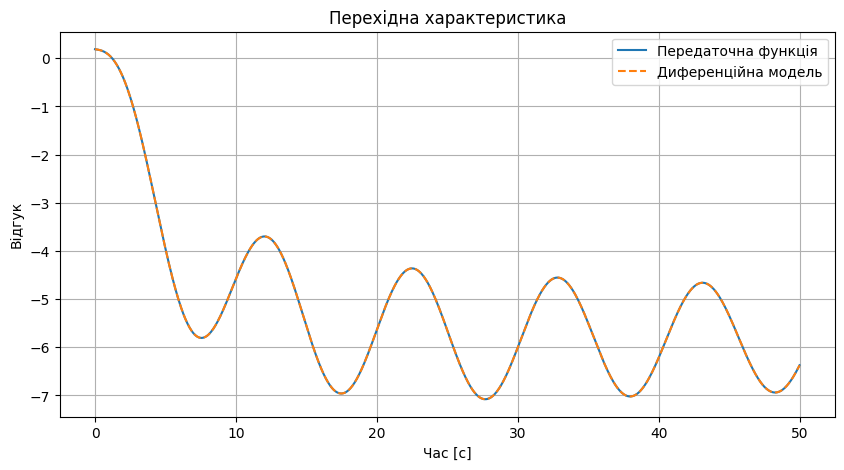

In [34]:
from sympy import symbols, Function, Eq, Derivative, pprint

num_coeff = stable_sys.num
den_coeff = stable_sys.den

# Визначаємо змінну часу та функції u(t) і y(t)
t = symbols('t')
u = Function('u')(t)
y = Function('y')(t)

# Генеруємо диференційне рівняння
lhs = sum(den_coeff[i] * Derivative(y, (t, i)) for i in range(len(den_coeff)))
rhs = sum(num_coeff[i] * Derivative(u, (t, i)) for i in range(len(num_coeff)))

# Формуємо рівняння
differential_equation = Eq(lhs, rhs)

# Виводимо диференційне рівняння

pprint(differential_equation)

#система рівнянь LTI
sys_diff_eq = signal.lti(num_coeff, den_coeff)

#час моделювання
t = np.linspace(0, 50, 1000)

#Ступінчата характеристика для передаточної функції
t1, y1 = ctl.step_response(G, T=t)

#Ступінчата характеристика для диференційного рівняння
t2, y2, _ = signal.lsim(sys_diff_eq, U=np.ones_like(t), T=t)

#Графік для порівняння
plt.figure(figsize=(10, 5))
plt.plot(t1, y1, label='Передаточна функція')
plt.plot(t2, y2, '--', label='Диференційна модель')
plt.title('Перехідна характеристика')
plt.xlabel('Час [с]')
plt.ylabel('Відгук')
plt.grid(True)
plt.legend()
plt.show()

## 2.1.2. Задача реалізації

In [38]:
# Створення передатної функції
sys = ctrl.TransferFunction(num_coeff, den_coeff)

# Крок 2: Перетворення на представлення у просторі станів
# Отримання об'єкта StateSpace
sys_ss = ctrl.tf2ss(sys)

# Доступ до матриць A, B, C, D
A = sys_ss.A
B = sys_ss.B
C = sys_ss.C
D = sys_ss.D

print("Матриці у просторі станів:")
print("A =", A)
print("B =", B)
print("C =", C)
print("D =", D)

# Крок 3: Реалізація канонічних форм вручну

# Канонічна форма керованості
def controllability_canonical_form(num, den):
    # Кількість станів
    n = len(den) - 1
    
    # Формування матриці A (супутня форма)
    A_cf = np.zeros((n, n))
    A_cf[0, :] = -np.array(den[1:])  # Знаменник зі знаком мінус
    A_cf[1:, :-1] = np.eye(n - 1)
    
    # Формування матриці B
    B_cf = np.zeros((n, 1))
    B_cf[-1, 0] = 1
    
    # Формування матриці C
    C_cf = np.array(num[1:] - num[0] * np.array(den[1:])).reshape(1, -1)
    
    # Матриця D
    D_cf = np.array([[num[0]]])
    
    return A_cf, B_cf, C_cf, D_cf

# Канонічна форма спостережуваності
def observability_canonical_form(num, den):
    # Кількість станів
    n = len(den) - 1
    
    # Формування матриці A
    A_of = np.zeros((n, n))
    A_of[:, -1] = -np.array(den[1:])
    A_of[:-1, 1:] = np.eye(n - 1)
    
    # Формування матриці B
    B_of = np.zeros((n, 1))
    B_of[0, 0] = 1
    
    # Формування матриці C
    C_of = np.array(num[1:] - num[0] * np.array(den[1:])).reshape(1, -1)
    
    # Матриця D
    D_of = np.array([[num[0]]])
    
    return A_of, B_of, C_of, D_of

# Отримання канонічної форми керованості
A_cf, B_cf, C_cf, D_cf = controllability_canonical_form(num_coeff, den_coeff)
print("\nКанонічна форма керованості:")
print("A =", A_cf)
print("B =", B_cf)
print("C =", C_cf)
print("D =", D_cf)

# Отримання канонічної форми спостережуваності
A_of, B_of, C_of, D_of = observability_canonical_form(num_coeff, den_coeff)
print("\nКанонічна форма спостережуваності:")
print("A =", A_of)
print("B =", B_of)
print("C =", C_of)
print("D =", D_of)

# Крок 4: Перевірка тотожності передатних функцій

# Передатна функція для канонічної форми керованості
sys_cf = ctrl.ss2tf(A_cf, B_cf, C_cf, D_cf)

# Передатна функція для канонічної форми спостережуваності
sys_of = ctrl.ss2tf(A_of, B_of, C_of, D_of)

# Перевірка тотожності передатних функцій
print("\nПередатна функція для КФК:", sys_cf)
print("Передатна функція для КФС:", sys_of)
print("Початкова передатна функція:", sys)

# Перевірка полюсів (власних значень матриці A)
poles_original = np.linalg.eigvals(A)
poles_cf = np.linalg.eigvals(A_cf)
poles_of = np.linalg.eigvals(A_of)

Матриці у просторі станів:
A = [[-0.18767773 -0.37535545 -0.06445498]
 [ 1.          0.          0.        ]
 [ 0.          1.          0.        ]]
B = [[1.]
 [0.]
 [0.]]
C = [[-0.03522293 -0.07044586 -0.38745221]]
D = [[0.18767773]]

Канонічна форма керованості:
A = [[-0.18767773 -0.37535545 -0.06445498]
 [ 1.          0.          0.        ]
 [ 0.          1.          0.        ]]
B = [[0.]
 [0.]
 [1.]]
C = [[-0.03522293 -0.07044586 -0.38745221]]
D = [[0.18767773]]

Канонічна форма спостережуваності:
A = [[ 0.          1.          0.        ]
 [ 0.          0.          1.        ]
 [ 0.          0.         -0.06445498]]
B = [[1.]
 [0.]
 [0.]]
C = [[-0.03522293 -0.07044586 -0.38745221]]
D = [[0.18767773]]

Передатна функція для КФК: <TransferFunction>: sys[112]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


0.1877 s^3 - 0.3522 s^2 + 3.886e-16 s - 0.1288
----------------------------------------------
    s^3 + 0.1877 s^2 + 0.3754 s + 0.06445

Передатна функція для КФС: <TransferFunction

## 2.3. Контрольні питання

### 2.3.1. Навіщо вводиться та розглядається таке різноманіття моделей лінійної поведінки?
Різноманіття моделей лінійної поведінки вводиться з кількох причин:

- **Адаптація до різних умов і задач**: Різні моделі можуть краще підходити для різних умов, наприклад, статичних або динамічних процесів, систем з затримками, нелінійних або мультиваріативних систем.
  
- **Зручність аналізу**: Деякі моделі (наприклад, простір станів або передатна функція) зручніші для певних типів аналізу, таких як стійкість, керованість, спостережуваність, що спрощує аналіз і синтез систем управління.

- **Точність моделювання**: Кожна модель має свої обмеження та особливості, тому для різних задач потрібен різний рівень деталізації, точності й складності, що дає можливість точно відобразити динамічну поведінку системи.

- **Практичність реалізації**: Моделі можуть використовуватися для різних цілей – для розробки алгоритмів управління, симуляцій, тестування, або як спрощені моделі для реального обладнання. Використання різноманітних моделей дає змогу вибрати найбільш практичну для конкретного завдання.

### 2.3.2. Яким є критерій фізичної реалізованості передатної функції?
Передатна функція вважається фізично реалізованою, якщо її можна реалізувати за допомогою реальних компонентів, таких як резистори, конденсатори, індуктивності, підсилювачі та інші. Для цього повинні виконуватися такі критерії:

- **Система має бути причинною**: Вхід повинен впливати на вихід у майбутньому, а не навпаки. Це означає, що порядок знаменника передатної функції має бути більшим або дорівнювати порядку чисельника.

- **Стійкість системи**: Система повинна бути стійкою, тобто всі полюси передатної функції повинні лежати в лівій частині комплексної площини (для безперервних систем) або всередині одиничного кола (для дискретних систем).

Ці критерії є необхідними для того, щоб передатна функція могла бути реалізована фізично і не вела до нереалістичних або нестабільних відповідей системи.